### CNN CIFAR10 Classifier ###

In [ ]:
!pip install --upgrade coremltools

     |████████████████████████████████| 3.4MB 8.3MB/s 
  Created wheel for attr: filename=attr-0.3.1-cp37-none-any.whl size=2458 sha256=f1a25d7b89f0ee9b5e10bee465fcc0b73c588442742091e687ca9de65e86e3e5
  Stored in directory: /root/.cache/pip/wheels/f0/96/9b/1f8892a707d17095b5a6eab0275da9d39e68e03a26aee2e726
Successfully built attr


In [ ]:
import keras                        # keras is a wrapper for tensorflow
from keras.models import Model
from keras.layers import *
from keras.utils.vis_utils import plot_model

import numpy as np
import cv2 as cv
import matplotlib as mpl            # matplotlib is used to show images since we cannot open a window
from matplotlib import pyplot as plt

import coremltools as ct

Get the data set


In [ ]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
  
label_strings = load_label_names()

cifar10 = keras.datasets.cifar10
(training_images, training_labels), (test_images, test_labels) = cifar10.load_data()


170500096/170498071 [==============================] - 3s 0us/step


Print the dataset


Objects shape: (50000, 32, 32, 3)
Labels shape: (50000, 1)
Number of classes: 10
[6]


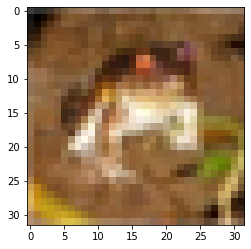

In [ ]:
print('Objects shape:',training_images.shape)
print('Labels shape:',training_labels.shape)
numClasses = np.max(training_labels)+1
print('Number of classes:',numClasses)
plt.imshow(training_images[0])
print(training_labels[0])

Convert to float32 and normalize the data


In [ ]:
# Parse numbers as floats
training_images = training_images.astype('float32')
test_images = test_images.astype('float32')

# Normalize data
training_images = training_images / 255
test_images = test_images / 255

Compute and subtract the mean intensity

In [ ]:
training_mean = np.mean(training_images)  
training_images -= training_mean
test_images -= training_mean

Now design the model


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0     

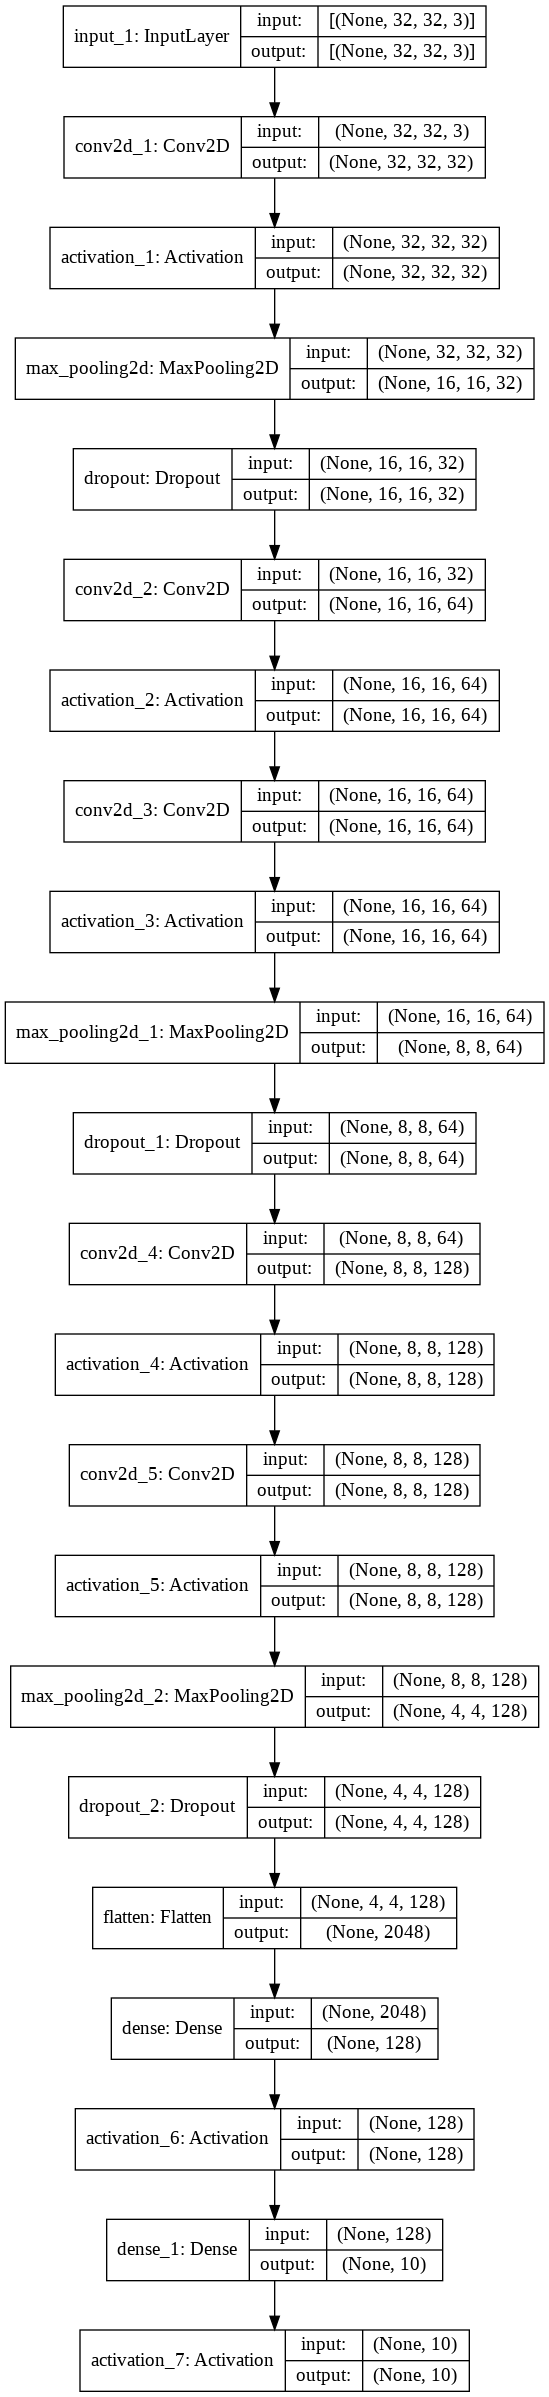

In [ ]:
# VGG-like network architecture
x_in = Input(training_images.shape[1:])
# size is 32x32

# take previous output and use it as input in each block
# First block
x = Conv2D(32,3,padding='same')(x_in)   
x = Activation('relu')(x)  
x = Conv2D(32,3,padding='same')(x_in)   
x = Activation('relu')(x)              
x = MaxPooling2D(2,2)(x)               
x = Dropout(0.1)(x)
# size is now 16x16

# Second block
x = Conv2D(64,3,padding='same')(x)
x = Activation('relu')(x)
x = Conv2D(64,3,padding='same')(x)
x = Activation('relu')(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.25)(x)
# size is now 8x8

# Third block
x = Conv2D(128,3,padding='same')(x)
x = Activation('relu')(x)
x = Conv2D(128,3,padding='same')(x)
x = Activation('relu')(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.5)(x)
# size is now 4x4

# Flatten to a vector, since we're 4x4 now
x = Flatten()(x)

# Dense (fully-connected) layer
x = Dense(128)(x)
x = Activation('relu')(x)

# Output layer, should always be equal to number of classifers
# or whatever you're looking for
x = Dense(numClasses)(x)    # output numClasses = 100
x = Activation('softmax')(x)  # softmax normalizes probablities so they add to 1

model = Model(inputs=x_in,outputs=x)
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Layer (type)                 Output Shape              Param #   
# =================================================================
# input_1 (InputLayer)         (None, 32, 32, 3)         0

# output is the image we're looking at, index
# (None, 32, 32, 1)  then H, W, channel
# 32x32x3 because 3 is RGB

Compile the model and train


In [ ]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=keras.optimizers.Adam(lr=3e-4),metrics=['sparse_categorical_accuracy'])
history = model.fit(training_images,training_labels,
          shuffle=True,
          epochs=25,
          batch_size=64,
          validation_split=0.1)

Epoch 1/25
704/704 [==============================] - 38s 7ms/step - loss: 1.9005 - sparse_categorical_accuracy: 0.2988 - val_loss: 1.3081 - val_sparse_categorical_accuracy: 0.5226
Epoch 2/25
704/704 [==============================] - 4s 6ms/step - loss: 1.3308 - sparse_categorical_accuracy: 0.5136 - val_loss: 1.1098 - val_sparse_categorical_accuracy: 0.6070
Epoch 3/25
704/704 [==============================] - 4s 6ms/step - loss: 1.1578 - sparse_categorical_accuracy: 0.5843 - val_loss: 0.9913 - val_sparse_categorical_accuracy: 0.6558
Epoch 4/25
704/704 [==============================] - 4s 6ms/step - loss: 1.0395 - sparse_categorical_accuracy: 0.6266 - val_loss: 0.9109 - val_sparse_categorical_accuracy: 0.6888
Epoch 5/25
704/704 [==============================] - 4s 6ms/step - loss: 0.9577 - sparse_categorical_accuracy: 0.6571 - val_loss: 0.8459 - val_sparse_categorical_accuracy: 0.7072
Epoch 6/25
704/704 [==============================] - 4s 6ms/step - loss: 0.8798 - sparse_categoric

Compare training and testing perforamance


In [ ]:
results = model.evaluate(training_images,training_labels,verbose=0)
print('Training Accuracy: %.2f %%'%(results[1]*100))
results = model.evaluate(test_images,test_labels,verbose=0)
print('Testing Accuracy: %.2f %%'%(results[1]*100))

Training Accuracy: 92.60 %
Testing Accuracy: 80.77 %


Plot the results


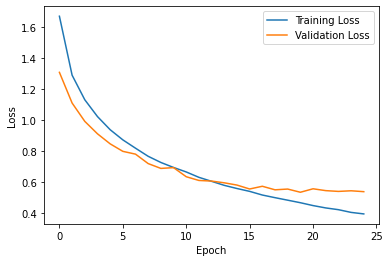

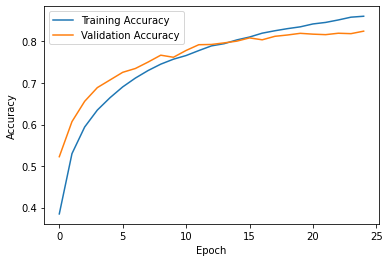

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Display probabilities as an image


output shape:  (10000, 10)
[5.1753668e-05 2.5872517e-04 3.2189547e-09 1.3856815e-08 5.2574051e-10
 8.9717300e-10 2.2674624e-09 3.8666059e-10 9.9968672e-01 2.8049285e-06]


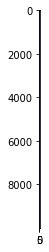

In [ ]:
preds = model.predict(test_images,verbose=0)
print('output shape: ',preds.shape)
print(preds[1])
plt.imshow(preds)
plt.show()

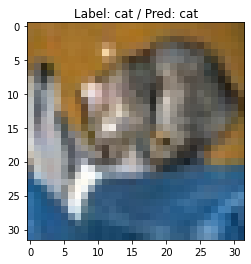

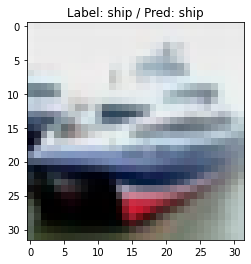

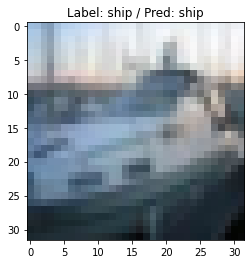

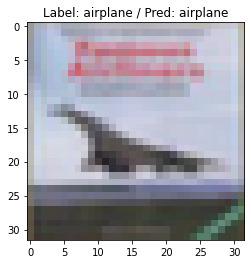

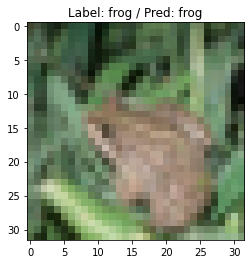

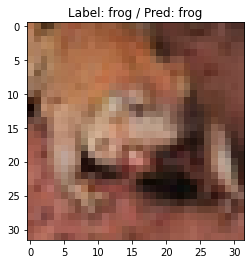

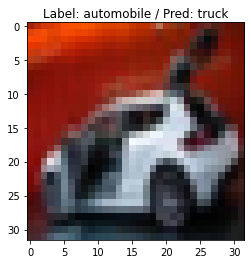

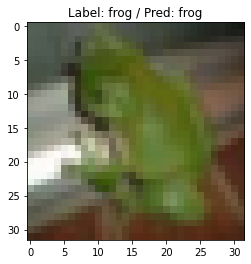

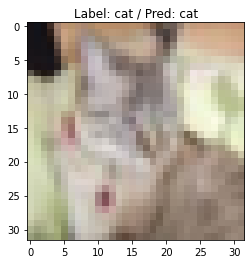

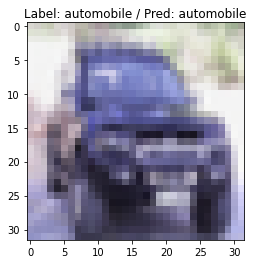

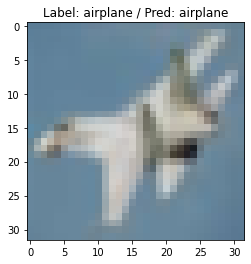

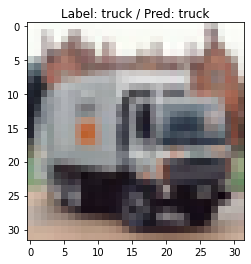

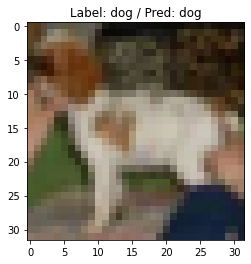

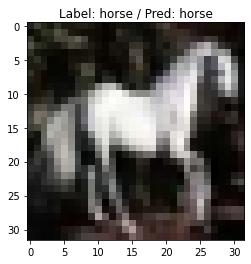

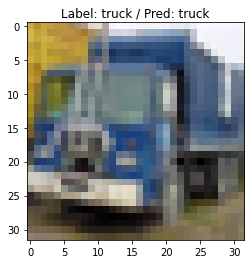

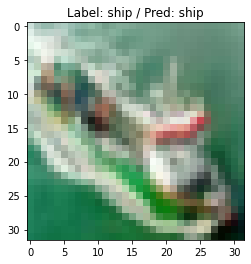

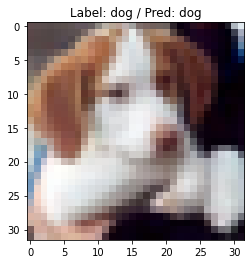

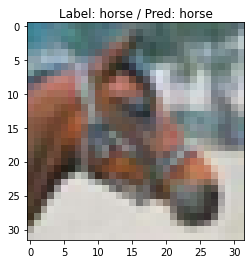

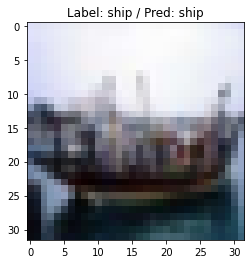

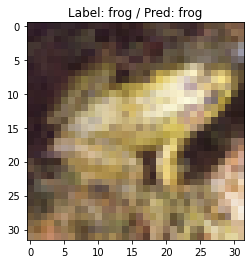

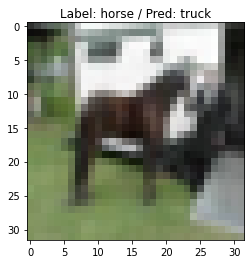

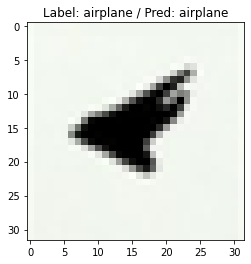

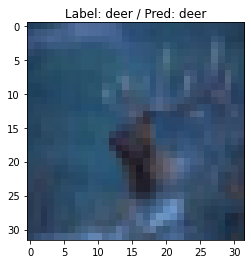

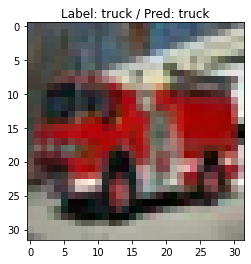

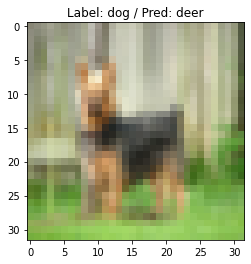

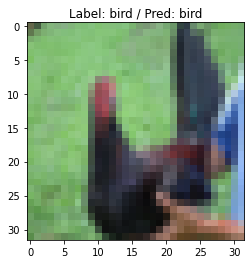

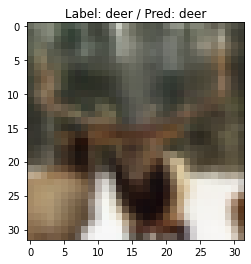

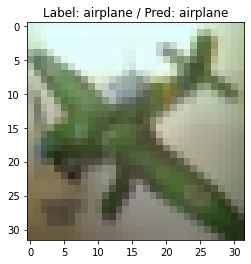

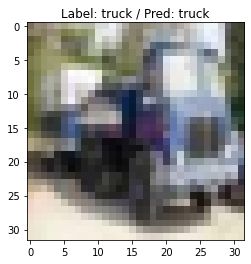

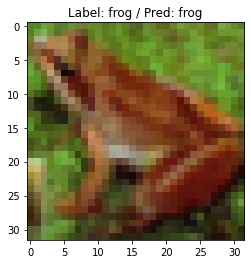

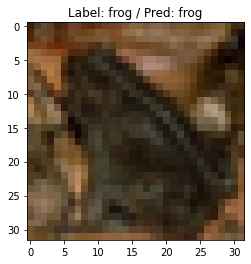

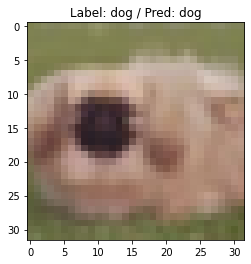

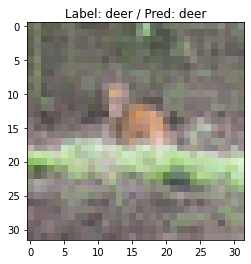

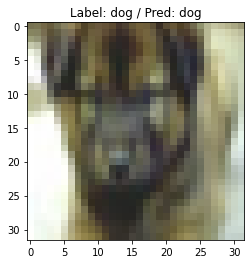

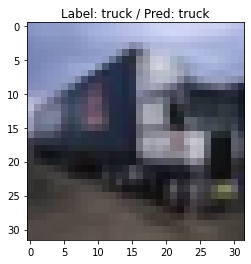

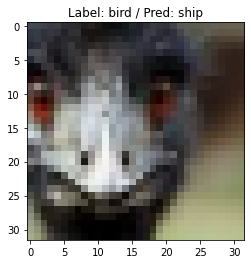

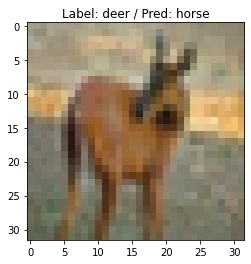

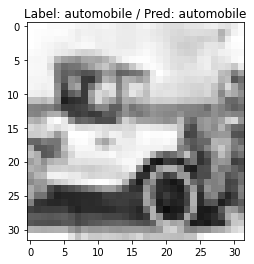

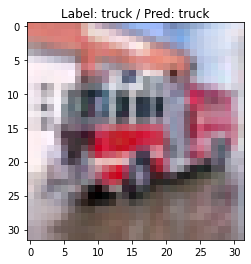

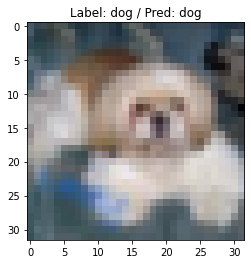

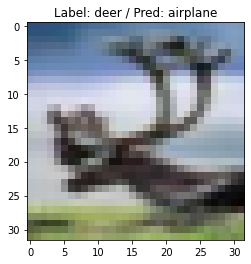

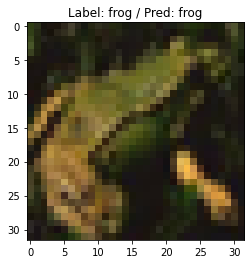

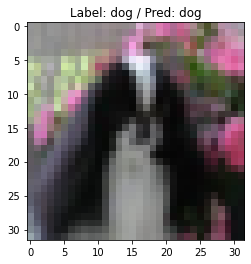

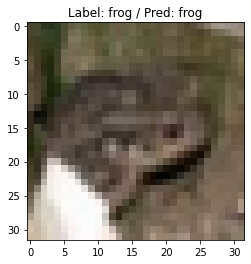

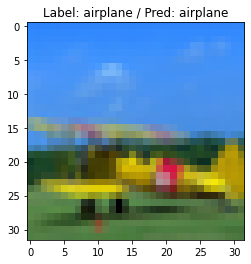

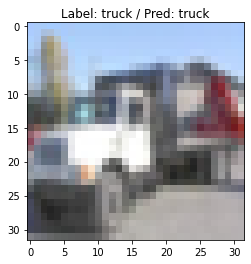

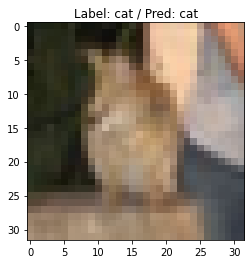

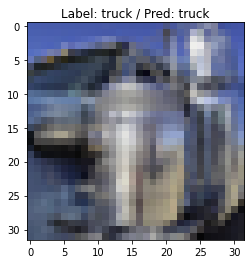

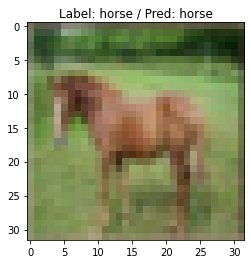

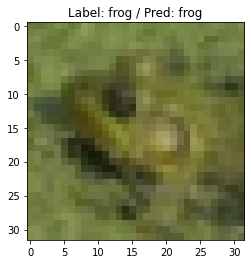

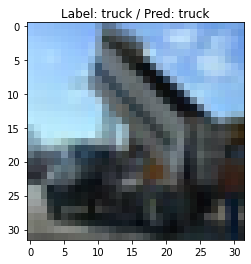

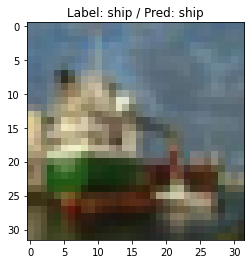

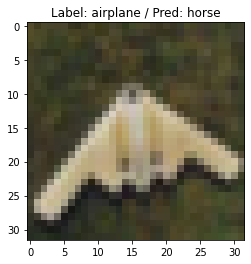

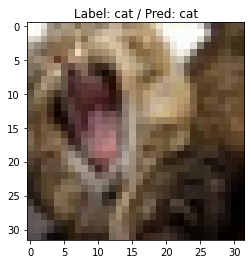

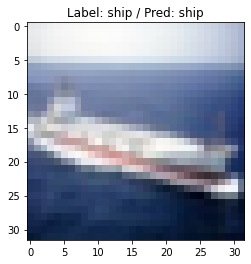

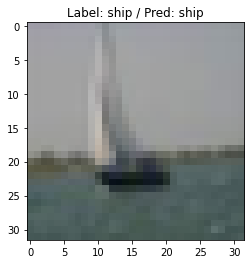

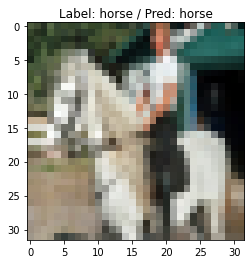

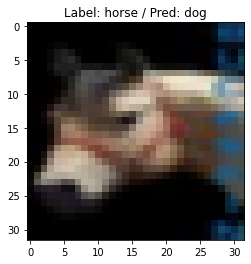

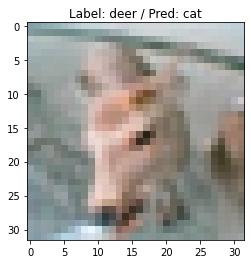

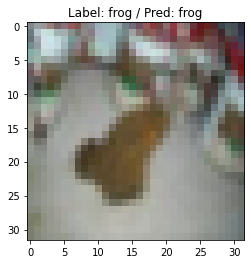

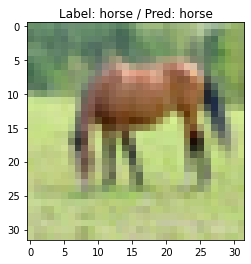

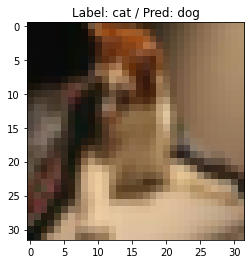

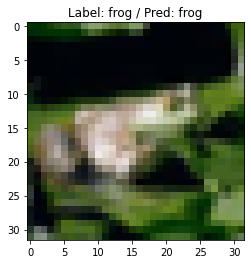

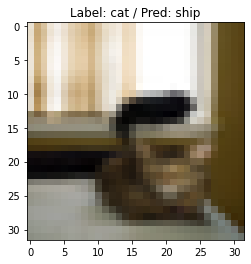

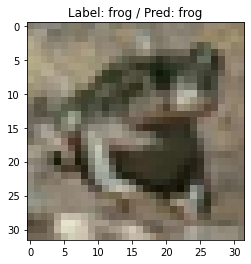

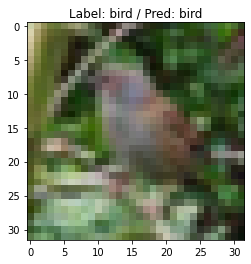

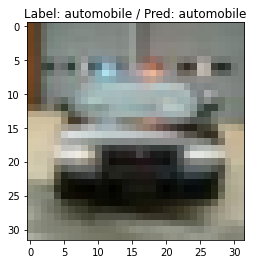

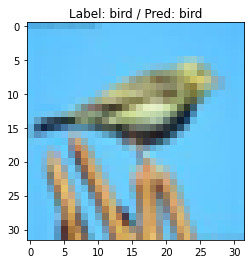

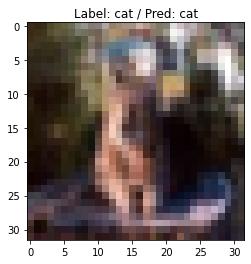

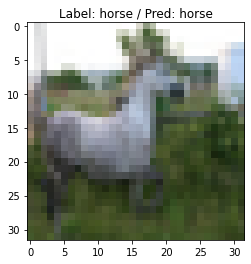

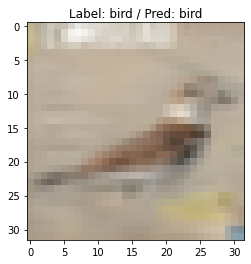

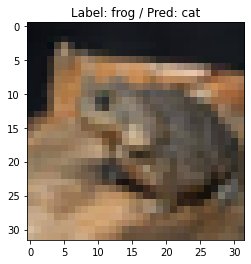

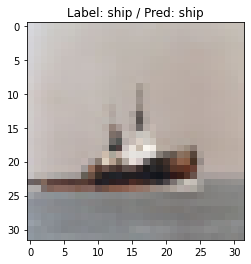

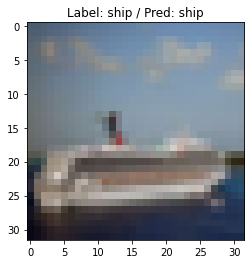

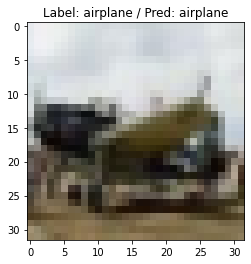

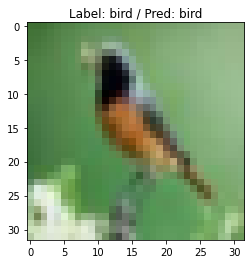

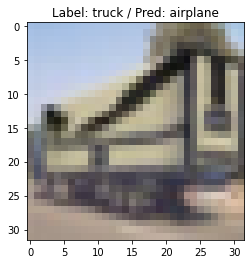

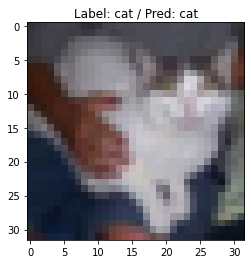

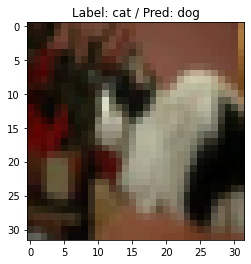

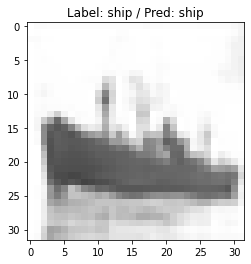

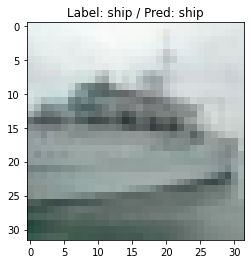

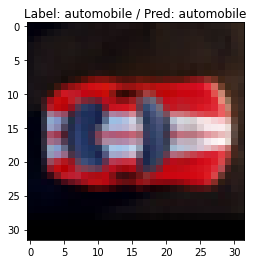

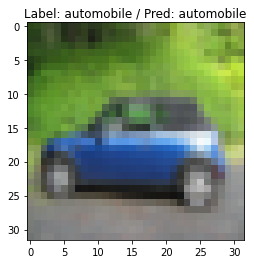

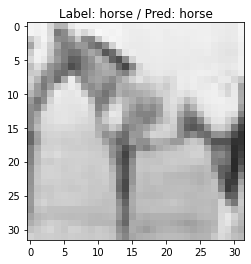

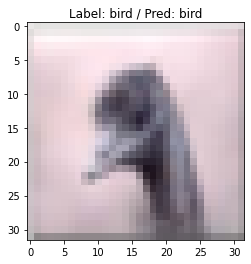

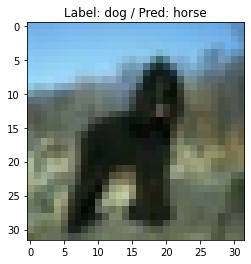

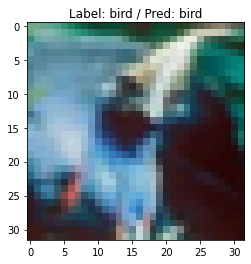

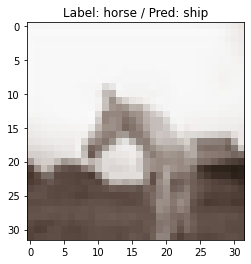

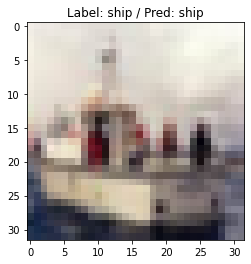

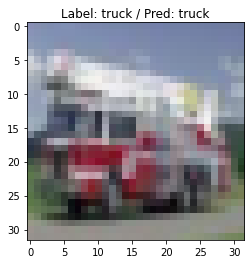

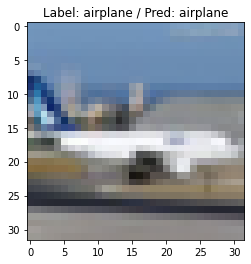

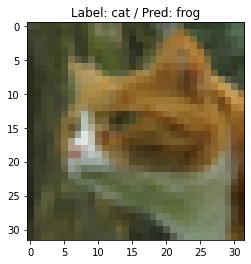

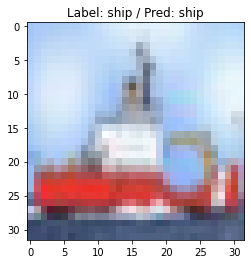

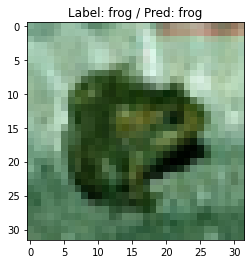

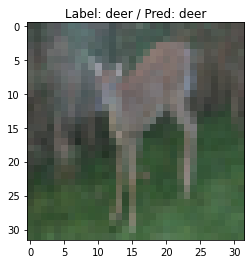

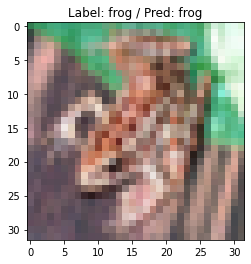

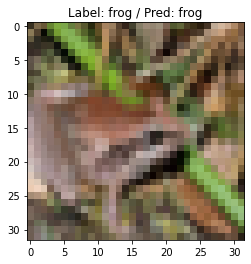

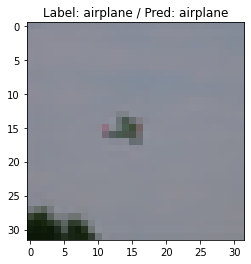

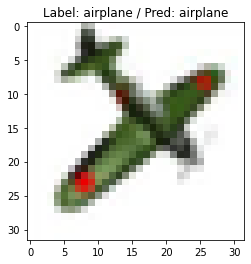

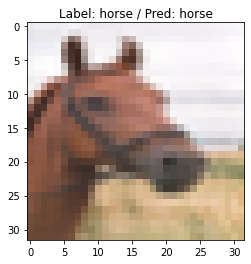

In [ ]:
i = 0;
for im,label,pred in zip(test_images,test_labels,preds):
  if i == 100:
    break
  predlabel = np.argmax(pred)
  imout = ((np.squeeze(im)+training_mean)*255).astype('uint8')
  plt.imshow(imout)
  plt.title('Label: %s / Pred: %s'%(label_strings[label[0]],label_strings[predlabel]))
  plt.show()
  i+=1



Convert the model to CoreML


In [ ]:
# Define the input type as image, 
# set pre-processing parameters to normalize the image 
# to have its values in the interval [-1,1] 
# as expected by the mobilenet model
image_input = ct.ImageType(shape=(1, 32, 32, 3,),
                           bias=[-1,-1,-1], scale=1/127)

# set class labels
classifier_config = ct.ClassifierConfig(label_strings)

# Convert the model using the Unified Conversion API
coreML_model = ct.convert(
    model, inputs=[image_input], classifier_config=classifier_config,
)

Translating MIL ==> MLModel Ops: 100%|██████████| 73/73 [00:00<00:00, 1021.50 ops/s]


Set CoreML Metadata


In [ ]:
# Set feature descriptions (these show up as comments in XCode)
coreML_model.input_description["input_1"] = "Input image to be classified"
coreML_model.output_description["classLabel"] = "Most likely image category"

# Set model author name
coreML_model.author = "Ethan Franciliso"

# Set a short description for the Xcode UI
coreML_model.short_description = "Classifies images into categories based on the CIFAR-10 dataset training"

# Set a version for the model
coreML_model.version = "1.0"

Save the model


In [ ]:
coreML_model.save("CIFAR-10_First_CNN.mlmodel")
!zip -r CIFAR-10_First_CNN CIFAR-10_First_CNN.mlmodel

  adding: CIFAR-10_First_CNN.mlmodel (deflated 7%)
